# DCGAN으로 CIFAR10 이미지 생성하기<span class="tocSkip">

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-데이터셋-구성하기" data-toc-modified-id="1.-데이터셋-구성하기-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1. 데이터셋 구성하기</a></span></li><li><span><a href="#2.-생성자-모델-구현하기" data-toc-modified-id="2.-생성자-모델-구현하기-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. 생성자 모델 구현하기</a></span></li><li><span><a href="#3.-판별자-모델-구현하기" data-toc-modified-id="3.-판별자-모델-구현하기-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3. 판별자 모델 구현하기</a></span></li><li><span><a href="#4.-손실함수와-최적화-함수-구현하기" data-toc-modified-id="4.-손실함수와-최적화-함수-구현하기-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>4. 손실함수와 최적화 함수 구현하기</a></span></li><li><span><a href="#5.-훈련과정-상세-기능-구현하기" data-toc-modified-id="5.-훈련과정-상세-기능-구현하기-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>5. 훈련과정 상세 기능 구현하기</a></span></li><li><span><a href="#6.-학습-과정-진행하기" data-toc-modified-id="6.-학습-과정-진행하기-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>6. 학습 과정 진행하기</a></span></li><li><span><a href="#7.-GAN-훈련-과정-개선하기" data-toc-modified-id="7.-GAN-훈련-과정-개선하기-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>7. GAN 훈련 과정 개선하기</a></span></li></ul></div>

# 1. 데이터셋 구성하기
- 학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [1]:
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history
# 기존의 파일과 폴더에는 숫자를 붙여서 보관하고 매번 돌려볼 때마다 새로 생성한다.

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [5]:
train_img = train_x
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [6]:
train_x.shape

(50000, 32, 32, 3)

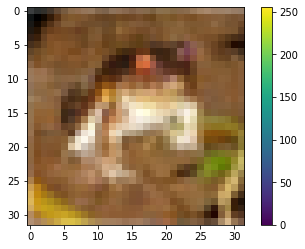

In [7]:
plt.imshow(train_img[0].reshape(32, 32, 3))
plt.colorbar()
plt.show()

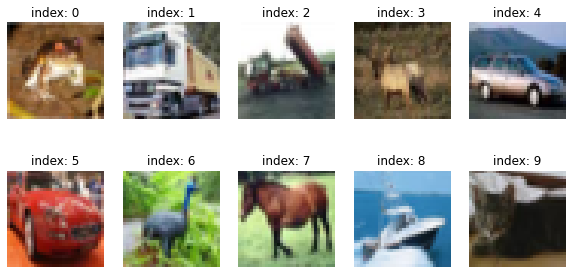

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_img[i].reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

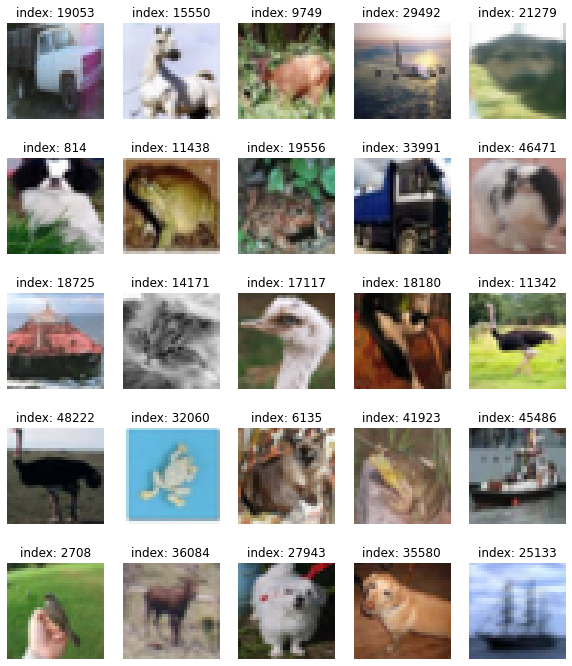

In [9]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_img[random_index].reshape(32, 32, 3))
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [10]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 2. 생성자 모델 구현하기
- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

In [12]:
def make_generator_model():
    # Start
    model = tf.keras.Sequential()
    dropout = 0.4
    depth = 256
    dim = 4
    # First: Dense layer
    model.add(layers.Dense(4*4*256, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    model.add(Reshape((dim, dim, depth)))
    model.add(Dropout(dropout))
    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))
    # Third: Conv2DTranspose layer       
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(int(depth/2), (4,4), padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    # Fourth: Conv2DTranspose layer
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(int(depth/4), (4,4), padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    # Fifth: Conv2DTranspose layer
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(int(depth/8), (4,4), padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    # Sixth: Conv2DTranspose layer
    model.add(Conv2DTranspose(3, (3,3), padding='same'))
    model.summary()
    return model


In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 256)         0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0

In [14]:
# 랜덤 노이즈 벡터 생성
noise = tf.random.normal([1, 100])

In [15]:
# 생성자 모델에 입력값으로 노이즈를 넣고 결과 이미지 생성
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

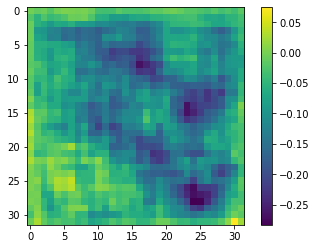

In [16]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

# 3. 판별자 모델 구현하기
- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [17]:
def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()
    # First: Conv2D Layer
    depth = 32
    dropout = 0.4
    model.add(Conv2D(depth*1, (3, 3), input_shape=[32, 32, 3], padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*2, (3, 3), strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*4, (3, 3), strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*8, (3, 3), strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))
        
    model.add(Flatten())
    model.add(Dense(1))
    model.summary()
    return model


In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)        

In [19]:
# 위에서 생성한 가짜 이미지를 판별자에 입력
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00123741]], dtype=float32)>

# 4. 손실함수와 최적화 함수 구현하기
- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [25]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 5. 훈련과정 상세 기능 구현하기
- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [26]:
# @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환됩니다.
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [27]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [29]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 6. 학습 과정 진행하기
- 위 STEP 5에서 구현한 기능들을 활용하여 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.

In [30]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [31]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

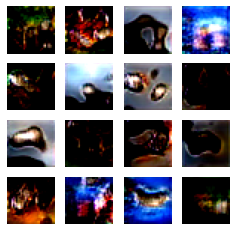

Time for training : 2580 sec


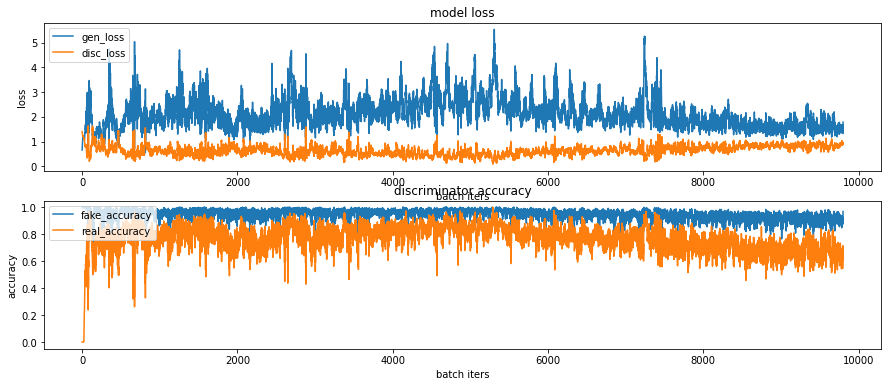

CPU times: user 42min 34s, sys: 35.5 s, total: 43min 9s
Wall time: 43min 1s


In [32]:
%%time
train(train_dataset, EPOCHS, save_every)

In [33]:
# 학습과정 시각화하기
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1069443 Sep  3 01:38 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

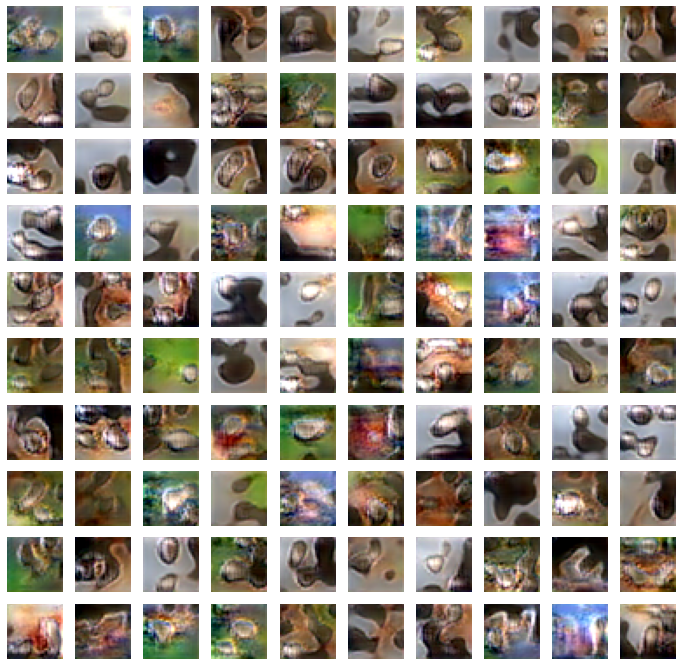

In [34]:
# checkpoint를 통해 모델 로드
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다.
plt.figure(figsize=(12, 12))

for i in range(100):
    plt.subplot(10, 10, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.axis('off')
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

다른 캠퍼스 퍼실이신 고은채님이 해두신걸 그대로 가져다 썼다.  
거기서 모델 부분의 레이어나 수치만 조금 바꿨는데  
내가 하니까 암만 해봐도 이상한 그림만 나오길래  
https://github.com/roatienza/Deep-Learning-Experiments/blob/master/Experiments/Tensorflow/GAN/dcgan_mnist.py  
여기서 모델 부분을 가져왔다.
그래도 안되네... 그냥 에폭을 500 이상으로 하는게 그나마 추상화라도 건지는 방법인건가 싶다....  
아니 더 이상해지네...?????  
판별자 잘못됐나보다....ㅠㅠ  
오... 몬가... 그럴듯하게 보이는게 생긴거 같기도 하다...!